In [1]:
import sys
sys.path.insert(1, '../src/')
from scot import *

In [2]:
import scipy as sp
import matplotlib.pyplot as plt

from kneed import KneeLocator
import math

import time

# For optimal transport operations:
import ot

# For pre-processing, normalization
from sklearn.preprocessing import StandardScaler, normalize

import numpy as np
import random, math, os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn, optim
from torch.autograd import grad
import torch.nn.functional as F




# For computing graph distances:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, kneighbors_graph
from sklearn.metrics import DistanceMetric

def model(X,y,  epsilon =1e-3, tol= 1e-2, lr = 10, best_k = 5, n_neighbors = 10):
    
    print("model start")
    time1 = time.time()
    def kmeans_finder(X, best_k = best_k):
        
        # calculate the WSS for different number of clusters
        wss = []
        for k in range(1, 5):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X)
            wss.append(kmeans.inertia_)

        # find the elbow point using KneeLocator
        kl = KneeLocator(range(1, 5), wss, curve='convex', direction='decreasing')
        best_k = kl.elbow
        print(best_k)
        
    
        
    
        # plot the WSS against the number of clusters with the elbow point
        plt.plot(range(1, 5), wss)
        plt.xlabel('Number of clusters')
        plt.ylabel('Within-cluster sum of squares')
        plt.title('Elbow method for optimal number of clusters')
        plt.vlines(best_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
        plt.show()

        print('Best number of clusters:', best_k)

        
    
        # fit the KMeans model with k clusters
        kmeans = KMeans(n_clusters= best_k, random_state=42).fit(X)
    
        # get the centroids and labels
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
    
        # loop through each centroid and find the index of the closest point
        closest_idx = []
        for i in range(len(centroids)):
            distances = np.linalg.norm(X - centroids[i], axis=1)
            closest_idx.append(np.argmin(distances))

        
        # create a scatter plot of the data points
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
        # add the cluster centroids as black crosses
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='black')
        # add the closest index points as red dots
        plt.scatter(X[closest_idx, 0], X[closest_idx, 1], marker='o', s=100, color='red')

        plt.show()

        return best_k, closest_idx

    

    def distance_matrix(X,y):
        
        dist = DistanceMetric.get_metric('euclidean')
        C1 = dist.pairwise(X)
        C2 = dist.pairwise(y)
        return C1, C2


    def finding_triplets(dist_matrix):
        
        _, closest_idx = kmeans_finder(dist_matrix)
      
        triplets = []
        
        # neigh = NearestNeighbors(n_neighbors=random.randint(2, dist_matrix.shape[0]))
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        
        neigh.fit(dist_matrix)
        for i in range(len(closest_idx)):
            neigh_dist, neigh_ind = neigh.kneighbors([dist_matrix[closest_idx[i]]])
            j = neigh_ind[0][0]
            k = neigh_ind[0][1]
            l = neigh_ind[0][-1]
            triplets.append((j, k, l))
        return triplets



    
    # define the triplet margin loss function
    triplet_loss_fn = nn.TripletMarginLoss(margin=1)


    def min_gromov_wasserstein_distance1(C1_fixed, C2_fixed, C1, C2, p, q, nb_iter_max = 5, lr = lr, epsilon = epsilon, tol= tol):
    
        loss_iter = []
        
        triplets_1 = finding_triplets(C1_fixed.detach().cpu().numpy())
        
        triplets_2 = finding_triplets(C2_fixed.detach().cpu().numpy())
       
        
        for i in range(nb_iter_max):
            
            print('iter', i)

            loss1 = ot.gromov.entropic_gromov_wasserstein2(C1, C2, p, q, loss_fun="square_loss", epsilon = epsilon, tol=tol, verbose=True, log=False)
            
            loss2 = ot.gromov.entropic_gromov_wasserstein2(C1_fixed, C1, p, p, loss_fun="square_loss", epsilon = epsilon, tol=tol, verbose=True, log=False)

            loss3 = ot.gromov.entropic_gromov_wasserstein2(C2_fixed, C2, q, q, loss_fun="square_loss", epsilon = epsilon, tol=tol, verbose=True, log=False)
        
            loss4 = 0
            loss5 = 0
        
        
            # define the triplet margin loss function
            
            
            for triplet in triplets_1:
                
                anchor1 = C1[triplet[0]]
                pos1 = C1[triplet[1]] 
                neg1 = C1[triplet[2]]
            
                lossC1 = triplet_loss_fn(anchor1, pos1, neg1)
        
                # add the loss to the total loss for this iteration
                loss4 += lossC1
        
    
            for triplet in triplets_2:
                
                anchor2 = C2[triplet[0]] 
                pos2 = C2[triplet[1]] 
                neg2 = C2[triplet[2]]
                    
    
                lossC2 = triplet_loss_fn(anchor2, pos2, neg2)
        
                # add the loss to the total loss for this iteration
                loss5 += lossC2
    
            
            loss = (loss1 + loss2+ loss3) + 1/len(triplets_1)*loss4 + 1/len(triplets_2)*loss5
            #print(loss)
            loss_iter.append(loss.clone().detach().cpu().numpy())
    
        # Compute the gradient of the loss with respect to the cost matrices
                
            loss.backward()
            with torch.no_grad():
                
                grad_C1 = C1.grad
                
                grad_C2 = C2.grad
    
                # print('grad_C1:', grad_C1)
                # print('grad_C2:', grad_C2)
        
                C1 -= lr * grad_C1
                C2 -= lr * grad_C2
            
                
                for m in range(C1.shape[0]):
                    C1[m][m] = 0
             
                for m in range(C2.shape[0]):
                    C2[m][m] = 0

            

                C1.grad.zero_()
            
                C2.grad.zero_()
            
        
        # Convert the final tensors back to numpy arrays
        C1 = C1.detach().cpu().numpy()
        C2 = C2.detach().cpu().numpy()
    
        return C1, C2, loss_iter
    
    X, y  = normalize(X, norm="l2"), normalize(y, norm="l2")
  
    C1, C2 = distance_matrix(X, y)
    
    
    C1_torch = torch.tensor(C1, dtype=torch.float32, requires_grad=True)
    C2_torch = torch.tensor(C2, dtype=torch.float32, requires_grad=True)
  
   
    
    p = ot.unif(C1.shape[0])
    p = torch.tensor(p, dtype=torch.float32)
    q = ot.unif(C2.shape[0])
    q = torch.tensor(q, dtype=torch.float32)
    
    
    C1_opt, C2_opt, loss_iter = min_gromov_wasserstein_distance1(C1_torch, C2_torch, C1_torch, C2_torch, p, q)
    

    plt.figure()
    plt.plot(loss_iter)
    plt.title("Loss along iterations")
    
    time2 = time.time()
    print("model takes {:f}".format(time2-time1), 'seconds')

    return C1, C2, C1_opt, C2_opt

In [3]:
X=np.load("../data/scatac_feat.npy") 
y=np.load("../data/scrna_feat.npy")
print("Dimensions of input datasets are: ", "X= ", X.shape, " y= ", y.shape)

Dimensions of input datasets are:  X=  (1047, 19)  y=  (1047, 10)


In [4]:
X_example = X[0:5,0:3]
print(X_example)

[[60197.  6248.  4661.]
 [66853.  5991. 77816.]
 [13579.  1527.  1360.]
 [71872.  5936.  2560.]
 [30420.  3778.  2096.]]


In [5]:
y_example = y[0:5,0:5]
print(y_example)

[[  6.6883364   -2.3696006    2.14278082  -0.28129481   0.0990671 ]
 [ -1.64704263   3.87629104  -2.57201982  -0.26799879  -0.10307687]
 [ -3.22729615   4.55422489 -10.10911411  -0.35633895   0.13389332]
 [  8.39902905  -5.00142347  -0.21591065   0.20100497   0.11180953]
 [ 10.40509703  -5.58712509   0.23241886  -0.31585508  -0.36511944]]


model start
2


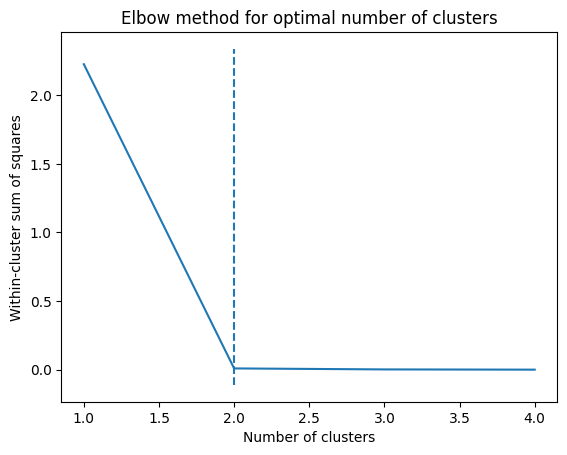

Best number of clusters: 2


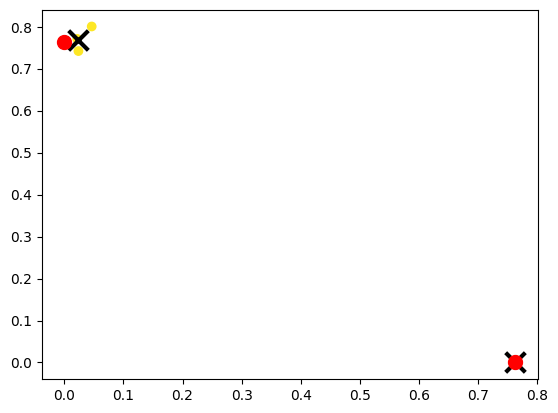

2


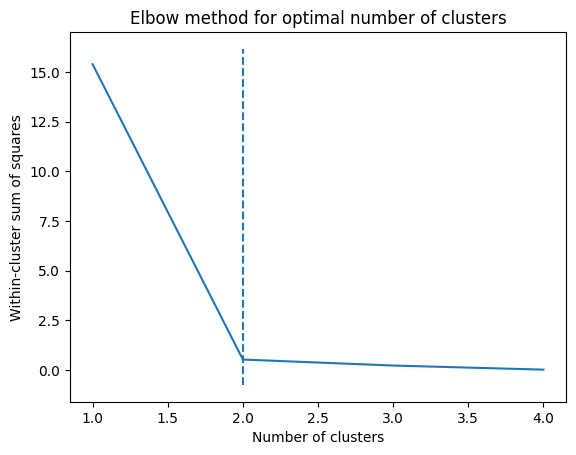

Best number of clusters: 2


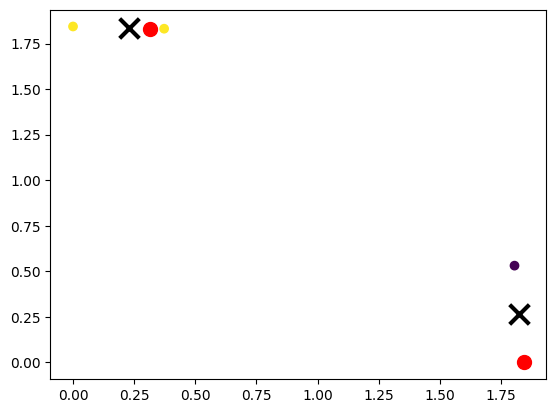

iter 0
It.  |Err         
-------------------
    0|1.283716e-01|
   10|9.413842e-07|
It.  |Err         
-------------------
    0|1.891161e-01|
   10|0.000000e+00|
It.  |Err         
-------------------
    0|1.676188e-01|
   10|3.811887e-03|
   20|2.638953e-05|
iter 1
It.  |Err         
-------------------
    0|1.522018e-01|
   10|1.192906e-03|
   20|1.507837e-05|
It.  |Err         
-------------------
    0|1.916449e-01|
   10|3.649787e-07|
It.  |Err         
-------------------
    0|1.706327e-01|
   10|5.186692e-06|
iter 2
It.  |Err         
-------------------
    0|1.499083e-01|
   10|3.897361e-04|
   20|2.802950e-06|
It.  |Err         
-------------------
    0|1.824069e-01|
   10|2.219750e-08|
It.  |Err         
-------------------
    0|1.677748e-01|
   10|8.372836e-06|
iter 3
It.  |Err         
-------------------
    0|1.537877e-01|
   10|1.355435e-05|
It.  |Err         
-------------------
    0|1.790740e-01|
   10|2.136660e-08|
It.  |Err         
-------------------
    

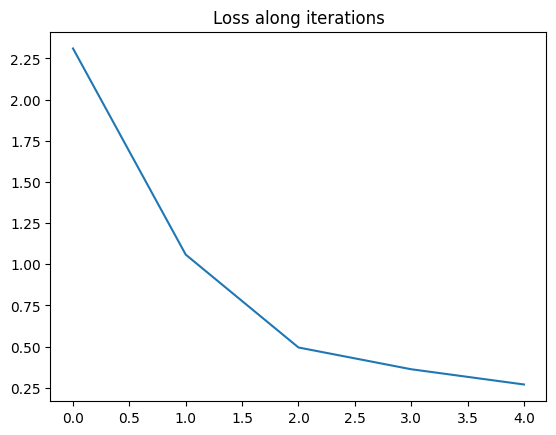

In [6]:
C1, C2, C1_opt, C2_opt = model(X_example, y_example,epsilon =1e-1, tol= 1e-4, lr = 1, n_neighbors = 3)

In [7]:
C1

array([[0.        , 0.76248841, 0.02390867, 0.04639248, 0.02184711],
       [0.76248841, 0.        , 0.74193054, 0.80051402, 0.77083552],
       [0.02390867, 0.74193054, 0.        , 0.0702034 , 0.03301074],
       [0.04639248, 0.80051402, 0.0702034 , 0.        , 0.05257014],
       [0.02184711, 0.77083552, 0.03301074, 0.05257014, 0.        ]])

In [8]:
C2

array([[0.        , 1.84358657, 1.80508104, 0.37252863, 0.31379649],
       [1.84358657, 0.        , 0.53137166, 1.83138424, 1.82863962],
       [1.80508104, 0.53137166, 0.        , 1.68678457, 1.70226317],
       [0.37252863, 1.83138424, 1.68678457, 0.        , 0.08790316],
       [0.31379649, 1.82863962, 1.70226317, 0.08790316, 0.        ]])

In [9]:
C1_opt

array([[ 0.        ,  1.3024572 ,  0.57170326, -0.10610238, -0.15481238],
       [ 1.0724078 ,  0.        ,  0.7761474 ,  1.0965401 ,  1.076925  ],
       [ 0.977336  ,  0.212552  ,  0.        ,  1.0039603 ,  0.96368736],
       [-0.0380483 ,  1.2692355 ,  0.40521434,  0.        , -0.03322345],
       [-0.00361463,  1.2442073 ,  0.5776353 ,  0.00594325,  0.        ]],
      dtype=float32)

In [10]:
C2_opt

array([[ 0.        ,  1.6337903 ,  1.553165  ,  1.0967761 ,  0.7476596 ],
       [ 1.5542763 ,  0.        ,  0.7309342 ,  1.5515637 ,  1.5506452 ],
       [ 1.3929435 ,  0.5335113 ,  0.        ,  1.3220189 ,  1.3306637 ],
       [ 0.4689443 ,  1.590138  ,  1.0554875 ,  0.        ,  0.00324949],
       [ 0.49228606,  1.5906514 ,  1.0185099 , -0.36214882,  0.        ]],
      dtype=float32)

In [11]:
p = ot.unif(C1.shape[0])
q = ot.unif(C2.shape[0])
distance_C1_C2 = ot.gromov.entropic_gromov_wasserstein2(C1, C2, p, q, loss_fun = 'square_loss', epsilon=1e-2)
print('distance between C1 and C2:', distance_C1_C2)

distance between C1 and C2: 0.9749538719413066


In [12]:
p = ot.unif(C1_opt.shape[0])
q = ot.unif(C2_opt.shape[0])
distance_C1_opt_C2_opt = ot.gromov.entropic_gromov_wasserstein2(C1_opt, C2_opt, p, q, loss_fun = 'square_loss', epsilon=1e-2)
print('distance between C1_opt and C2_opt:', distance_C1_opt_C2_opt)

distance between C1_opt and C2_opt: 0.445818507558624


In [13]:
p = ot.unif(C1_opt.shape[0])
q =  ot.unif(C2_opt.shape[0])
P = ot.gromov.entropic_gromov_wasserstein(C1_opt, C2_opt, p, q, loss_fun='square_loss', epsilon = 1e-1, log=False, verbose=True)

It.  |Err         
-------------------
    0|1.516063e-01|
   10|1.240787e-07|
   20|1.221517e-13|


In [14]:
# projection
#Projecting the first domain onto the second domain
y_new=normalize(y_example)
weights=np.sum(P,axis = 0)
X_new =np.matmul(P, normalize(y_example)) / weights[:, None]

In [15]:
import evals 

# We will use the average FOSCTTM measure implemented in evals.py for evaluation (metric used in the publication Demetci et al 2021)
# This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples. 
fracs=evals.calc_domainAveraged_FOSCTTM(X_new, y_new)
print("Average FOSCTTM score for this alignment with X onto Y is: ", np.mean(fracs))

Average FOSCTTM score for this alignment with X onto Y is:  0.15


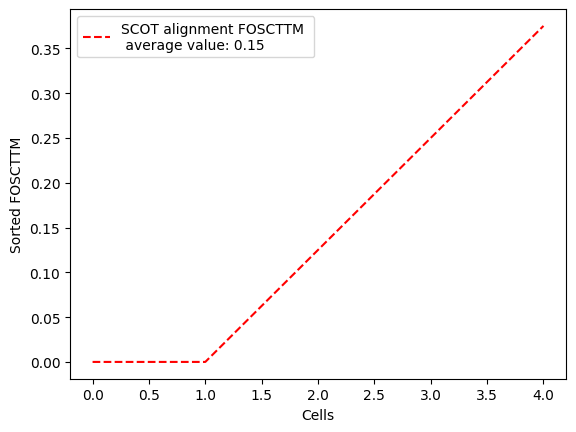

In [16]:
#Plotting sorted FOSCTTM to show the distributions of FOSCTTM across cells:

import matplotlib.pyplot as plt
legend_label="SCOT alignment FOSCTTM \n average value: "+str(np.mean(fracs)) #Put average FOSCTTM in the legend
plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

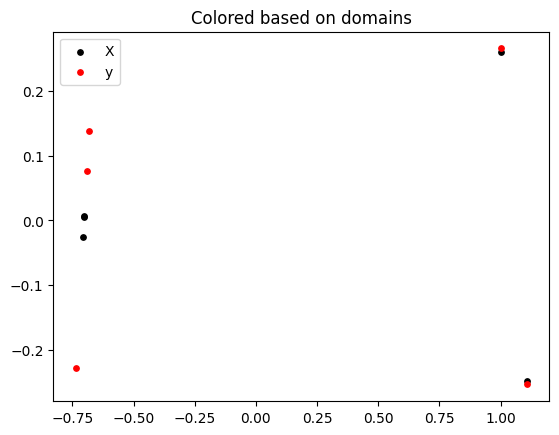

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Reduce the dimensionality of the aligned domains to two (2D) via PCA for the sake of visualization:
pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X_new, y_new), axis=0))
X_pca = Xy_pca[0:5,]
y_pca = Xy_pca[5:,]

#Plot aligned domains, samples colored by domain identity:
# plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="Chromatin Accessibility")
# plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="Gene Expression")
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="X")
plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="y")
plt.legend()
plt.title("Colored based on domains")
plt.show()

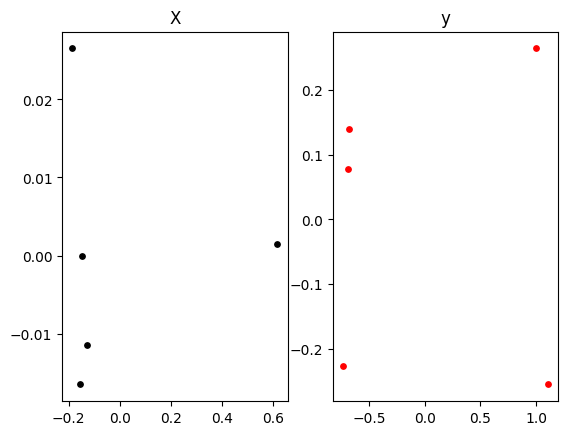

In [18]:
originalX_pca=pca.fit_transform(normalize(X_example))
originaly_pca=pca.fit_transform(normalize(y_example))

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c="k", s=15)
ax1.set_title("X")
# ax1.set_title("Chromatin Accessibiliy Domain \n *before* Alignment")
ax2.scatter(originaly_pca[:,0], originaly_pca[:,1], c="r", s=15)
# ax2.set_title("Gene Expression Domain \n *before* Alignment")
ax2.set_title("y")
plt.show()

In [19]:
# initialize SCOT object
original_scot=SCOT(X_example, y_example)
# call the alignment with l2 normalization 
X_new, y_new = original_scot.align(k=5, e=1e-3,  normalize=True, norm="l2")

It.  |Err         
-------------------
    0|1.040834e-16|


In [20]:
import evals 

# We will use the average FOSCTTM measure implemented in evals.py for evaluation (metric used in the publication Demetci et al 2021)
# This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples. 
fracs=evals.calc_domainAveraged_FOSCTTM(X_new, y_new)
print("Average FOSCTTM score for this alignment with X onto Y is: ", np.mean(fracs))

Average FOSCTTM score for this alignment with X onto Y is:  0.25


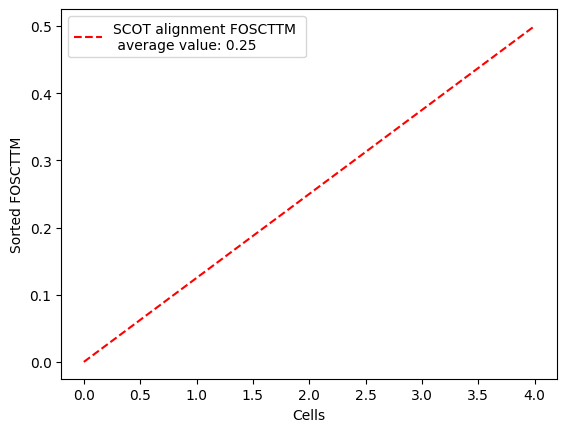

In [21]:
#Plotting sorted FOSCTTM to show the distributions of FOSCTTM across cells:

import matplotlib.pyplot as plt
legend_label="SCOT alignment FOSCTTM \n average value: "+str(np.mean(fracs)) #Put average FOSCTTM in the legend
plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

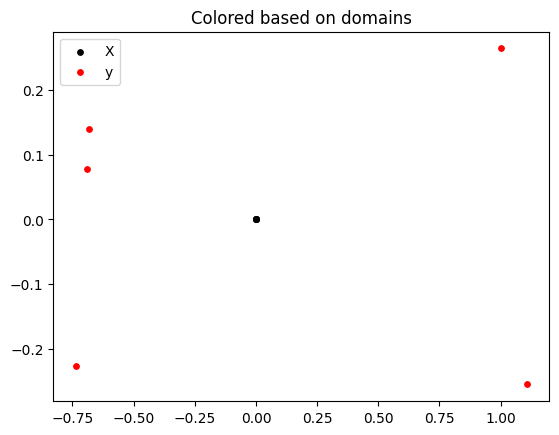

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Reduce the dimensionality of the aligned domains to two (2D) via PCA for the sake of visualization:
pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X_new, y_new), axis=0))
X_pca = Xy_pca[0:5,]
y_pca = Xy_pca[5:,]

#Plot aligned domains, samples colored by domain identity:
# plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="Chromatin Accessibility")
# plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="Gene Expression")
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="X")
plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="y")
plt.legend()
plt.title("Colored based on domains")
plt.show()

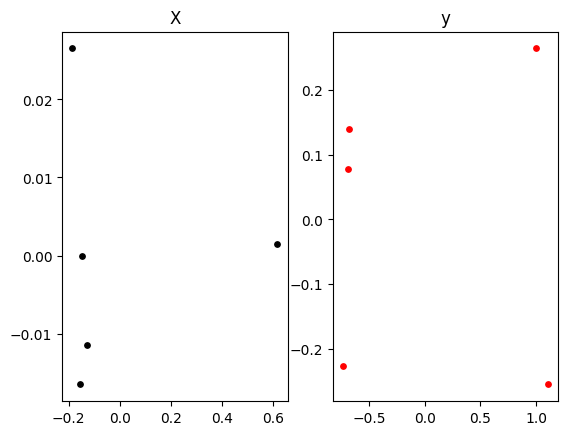

In [23]:
originalX_pca=pca.fit_transform(original_scot.X)
originaly_pca=pca.fit_transform(original_scot.y)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c="k", s=15)
# ax1.set_title("Chromatin Accessibiliy Domain \n *before* Alignment")
ax1.set_title("X")
ax2.scatter(originaly_pca[:,0], originaly_pca[:,1], c="r", s=15)
# ax2.set_title("Gene Expression Domain \n *before* Alignment")
ax2.set_title("y")
plt.show()

In [24]:
import scipy as sp
import matplotlib.pyplot as plt

from kneed import KneeLocator
import math

import random
import time

# For optimal transport operations:
import ot

# For pre-processing, normalization
from sklearn.preprocessing import StandardScaler, normalize

import numpy as np
import random, math, os, sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn, optim
from torch.autograd import grad
import torch.nn.functional as F




# For computing graph distances:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, kneighbors_graph
from sklearn.metrics import DistanceMetric

def model(X,y,  epsilon =1e-3, tol= 1e-2, lr = 10, best_k = 5, n_neighbors = 10):
    
    print("model start")
    time1 = time.time()
    def kmeans_finder(X, best_k = best_k):
        
        # calculate the WSS for different number of clusters
        wss = []
        for k in range(1, 5):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X)
            wss.append(kmeans.inertia_)

        # find the elbow point using KneeLocator
        kl = KneeLocator(range(1, 5), wss, curve='convex', direction='decreasing')
        best_k = kl.elbow
        print(best_k)
        
    
        
    
        # plot the WSS against the number of clusters with the elbow point
        plt.plot(range(1, 5), wss)
        plt.xlabel('Number of clusters')
        plt.ylabel('Within-cluster sum of squares')
        plt.title('Elbow method for optimal number of clusters')
        plt.vlines(best_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
        plt.show()

        print('Best number of clusters:', best_k)

        
    
        # fit the KMeans model with k clusters
        kmeans = KMeans(n_clusters= best_k, random_state=42).fit(X)
    
        # get the centroids and labels
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
    
        # loop through each centroid and find the index of the closest point
        closest_idx = []
        for i in range(len(centroids)):
            distances = np.linalg.norm(X - centroids[i], axis=1)
            closest_idx.append(np.argmin(distances))

        
        # create a scatter plot of the data points
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
        # add the cluster centroids as black crosses
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='black')
        # add the closest index points as red dots
        plt.scatter(X[closest_idx, 0], X[closest_idx, 1], marker='o', s=100, color='red')

        plt.show()

        return best_k, closest_idx

    

    def distance_matrix(X,y):
        
        dist = DistanceMetric.get_metric('euclidean')
        C1 = dist.pairwise(X)
        C2 = dist.pairwise(y)
        return C1, C2


    def finding_triplets(dist_matrix):
        
        _, closest_idx = kmeans_finder(dist_matrix)
      
        triplets = []
        
        # neigh = NearestNeighbors(n_neighbors=random.randint(2, dist_matrix.shape[0]))
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        
        neigh.fit(dist_matrix)
        for i in range(len(closest_idx)):
            neigh_dist, neigh_ind = neigh.kneighbors([dist_matrix[closest_idx[i]]])
            j = neigh_ind[0][0]
            k = neigh_ind[0][1]
            l = neigh_ind[0][-1]
            triplets.append((j, k, l))
        return triplets



    
    # define the triplet margin loss function
    triplet_loss_fn = nn.TripletMarginLoss(margin=1)


    def min_gromov_wasserstein_distance1(C2_fixed, C1, C2, p, q, nb_iter_max = 5, lr = lr, epsilon = epsilon, tol= tol):
    
        loss_iter = []
        
        #triplets_1 = finding_triplets(C1_fixed.detach().cpu().numpy())
        
        triplets_2 = finding_triplets(C2_fixed.detach().cpu().numpy())
       
        
        for i in range(nb_iter_max):
            
            print('iter', i)

            loss1 = ot.gromov.entropic_gromov_wasserstein2(C1, C2, p, q, loss_fun="square_loss", epsilon = epsilon, tol=tol, verbose=True, log=False)
        
            loss3 = ot.gromov.entropic_gromov_wasserstein2(C2_fixed, C2, q, q, loss_fun="square_loss", epsilon = epsilon, tol=tol, verbose=True, log=False)
        
            loss5 = 0
        
        
            # define the triplet margin loss function
                
            for triplet in triplets_2:
                
                anchor2 = C2[triplet[0]] 
                pos2 = C2[triplet[1]] 
                neg2 = C2[triplet[2]]
                    
    
                lossC2 = triplet_loss_fn(anchor2, pos2, neg2)
        
                # add the loss to the total loss for this iteration
                loss5 += lossC2
    
            
            loss = (loss1 + loss3) +  1/len(triplets_2)*loss5
            #print(loss)
            loss_iter.append(loss.clone().detach().cpu().numpy())
    
        # Compute the gradient of the loss with respect to the cost matrices
                
            loss.backward()
            with torch.no_grad():
                
                grad_C2 = C2.grad
    
                # print('grad_C2:', grad_C2)
        
                C2 -= lr * grad_C2
            
                for m in range(C2.shape[0]):
                    C2[m][m] = 0
          
                C2.grad.zero_()
            
        
        # Convert the final tensors back to numpy arrays
        C1 = C1.detach().cpu().numpy()
        C2 = C2.detach().cpu().numpy()
    
        return C1, C2, loss_iter
    
    X, y  = normalize(X, norm="l2"), normalize(y, norm="l2")
  
    C1, C2 = distance_matrix(X, y)
    
    
    C1_torch = torch.tensor(C1, dtype=torch.float32, requires_grad=True)
    
   
    
    p = ot.unif(C1_torch.shape[0])
    p = torch.tensor(p, dtype=torch.float32)
    
    
    C1_opt, C2_opt, loss_iter = min_gromov_wasserstein_distance1(C1_torch, C1_torch, C1_torch, p, p)
    

    plt.figure()
    plt.plot(loss_iter)
    plt.title("Loss along iterations")
    
    time2 = time.time()
    print("model takes {:f}".format(time2-time1), 'seconds')

    return C1, C2, C1_opt, C2_opt

model start
2


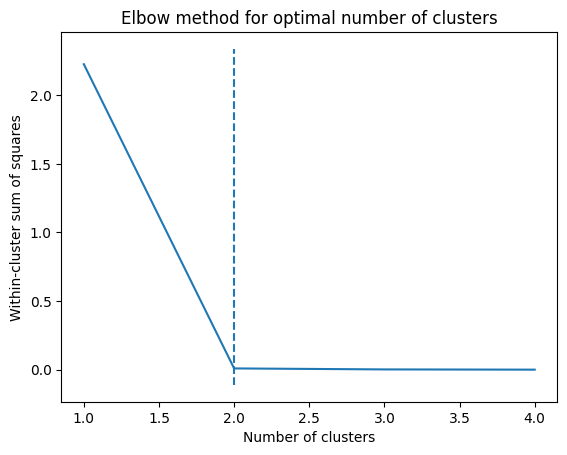

Best number of clusters: 2


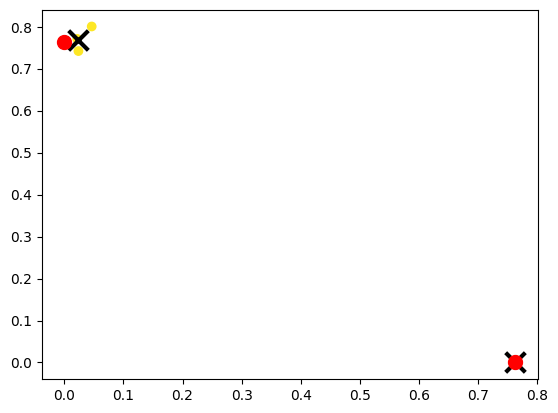

iter 0
It.  |Err         
-------------------
    0|2.731694e-02|
   10|1.219144e-07|
It.  |Err         
-------------------
    0|2.731694e-02|
   10|1.219144e-07|
iter 1
It.  |Err         
-------------------
    0|1.994231e-02|
   10|7.136629e-08|
It.  |Err         
-------------------
    0|1.994231e-02|
   10|7.136629e-08|
iter 2
It.  |Err         
-------------------
    0|9.446934e-03|
   10|2.326443e-08|
It.  |Err         
-------------------
    0|9.446934e-03|
   10|2.326443e-08|
iter 3
It.  |Err         
-------------------
    0|1.065142e-02|
   10|1.580507e-08|
It.  |Err         
-------------------
    0|1.065142e-02|
   10|1.580507e-08|
iter 4
It.  |Err         
-------------------
    0|7.977368e-03|
   10|2.526615e-08|
It.  |Err         
-------------------
    0|7.977368e-03|
   10|2.526615e-08|
model takes 12.503378 seconds


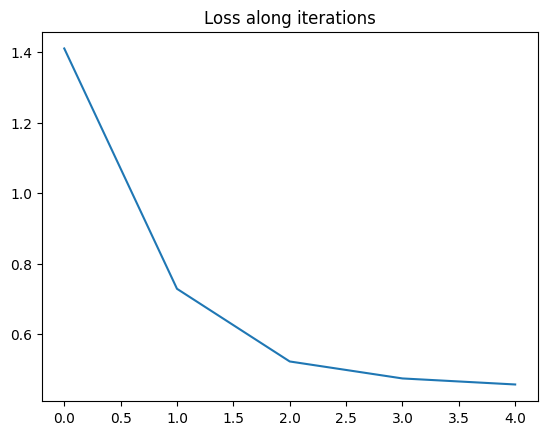

In [25]:
C1, C2, C1_opt, C2_opt = model(X_example, y_example,epsilon =1, tol= 1e-4, lr = 1, n_neighbors = 3)

In [26]:
C1

array([[0.        , 0.76248841, 0.02390867, 0.04639248, 0.02184711],
       [0.76248841, 0.        , 0.74193054, 0.80051402, 0.77083552],
       [0.02390867, 0.74193054, 0.        , 0.0702034 , 0.03301074],
       [0.04639248, 0.80051402, 0.0702034 , 0.        , 0.05257014],
       [0.02184711, 0.77083552, 0.03301074, 0.05257014, 0.        ]])

In [27]:
C2

array([[0.        , 1.84358657, 1.80508104, 0.37252863, 0.31379649],
       [1.84358657, 0.        , 0.53137166, 1.83138424, 1.82863962],
       [1.80508104, 0.53137166, 0.        , 1.68678457, 1.70226317],
       [0.37252863, 1.83138424, 1.68678457, 0.        , 0.08790316],
       [0.31379649, 1.82863962, 1.70226317, 0.08790316, 0.        ]])

In [28]:
C1_opt

array([[ 0.        ,  0.6555849 ,  0.23279443, -0.29763556, -0.16358212],
       [ 0.494123  ,  0.        ,  0.23152088,  0.51466167,  0.49194783],
       [ 0.72207475, -0.22728026,  0.        ,  0.73097634,  0.78352076],
       [ 0.04378103,  0.5037688 ,  0.06657012,  0.        ,  0.04257444],
       [ 0.09404929,  0.55713224,  0.53273475,  0.19504216,  0.        ]],
      dtype=float32)

In [29]:
C2_opt

array([[ 0.        ,  0.6555849 ,  0.23279443, -0.29763556, -0.16358212],
       [ 0.494123  ,  0.        ,  0.23152088,  0.51466167,  0.49194783],
       [ 0.72207475, -0.22728026,  0.        ,  0.73097634,  0.78352076],
       [ 0.04378103,  0.5037688 ,  0.06657012,  0.        ,  0.04257444],
       [ 0.09404929,  0.55713224,  0.53273475,  0.19504216,  0.        ]],
      dtype=float32)